In [12]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
from glob import glob
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import *
import torchvision

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1, 224, 224, 50)
0.0
1.1494253
0.0 1.0


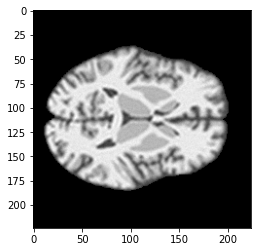

In [27]:
num = 100206
img = ImagePair(number=num, root_dir='data')
img_slice = img.subject()['LR'].numpy()[0,:,:,25]
plt.imshow(img_slice, cmap='gray')

print(img.subject()['LR'].shape)
print(img.subject()['LR'].numpy().min())
print(img.subject()['LR'].numpy().max())

min_val, max_val = np.percentile(img.subject()['LR'], (1, 99))
print(min_val, max_val)

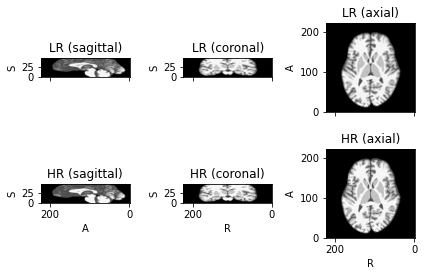

In [28]:
img.subject().plot()

In [29]:
train_subjects = data_split('training')
val_subjects = data_split('validation')

Load validation set	: 100%|███████████████| 30/30 [00:03<00:00,  7.53it/s]                                                             


In [30]:
std = 0.3548

training_transform = tio.Compose([
    Normalize(std=std),
    # tio.RandomNoise(p=0.5),
    # tio.RandomFlip(),
])

training_set = tio.SubjectsDataset(
    train_subjects, transform=training_transform)

val_set = tio.SubjectsDataset(
    val_subjects, transform=None)

In [51]:
training_batch_size = 32
validation_batch_size = 32

num_workers = 2
patch_size = (64,64)
ovl_perc = (.5, .5)
overlap, nr_patches = calculate_overlap(train_subjects[0]['LR'], patch_size, ovl_perc)
samples_per_volume = nr_patches

max_queue_length = samples_per_volume*10
sampler = tio.data.GridSampler(patch_size=(*patch_size,1), patch_overlap=overlap)#, padding_mode=0)

training_queue = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

val_queue = tio.Queue(
    subjects_dataset=val_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    training_queue, batch_size=training_batch_size)

val_loader = torch.utils.data.DataLoader(
    val_queue, batch_size=training_batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 1, 64, 64])


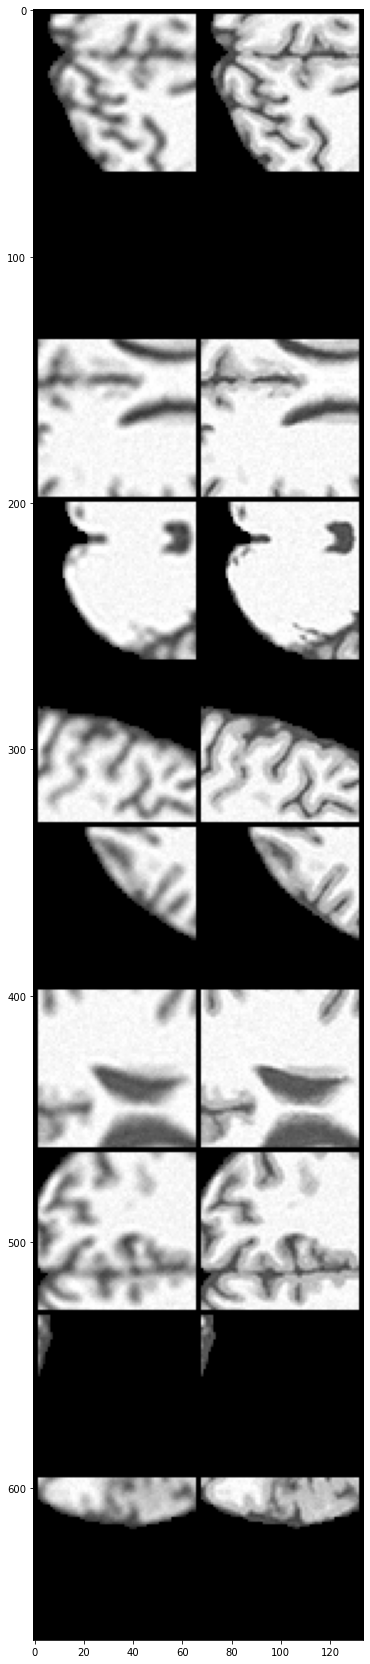

In [52]:
batch = next(iter(training_loader))

lr = batch['LR'][tio.DATA][:10]*std
hr = batch['HR'][tio.DATA][:10]*std

grid = torch.cat([torch.stack([a_row,b_row]) for a_row, b_row in zip(lr.squeeze(),hr.squeeze())]).unsqueeze(1)

print(grid.shape)
grid_img = torchvision.utils.make_grid(grid, nrow=2)

plt.figure(figsize=(10,30))
plt.imshow(grid_img.permute(1, 2, 0))

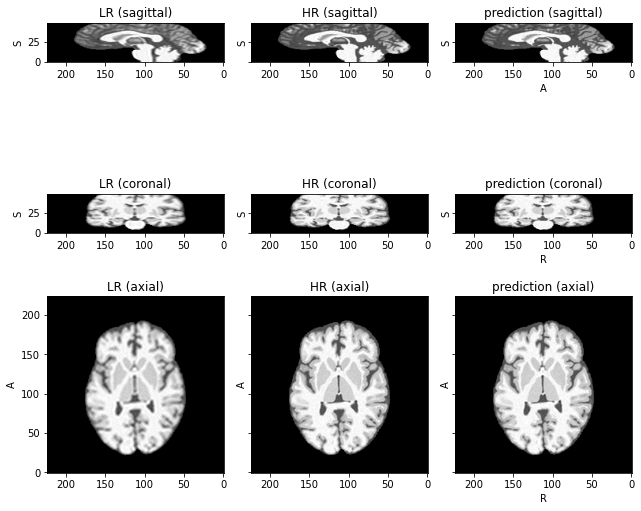

In [68]:
subject = random.choice(val_set)
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    patch_overlap=overlap,
    padding_mode='symmetric',
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['LR'][tio.DATA] / std
        locations = patches_batch[tio.LOCATION]
        probabilities = patches_batch['HR'][tio.DATA] # * std
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
prediction = tio.ScalarImage(tensor=foreground)
subject.add_image(prediction, 'prediction')
subject.plot(figsize=(9, 8))